In [32]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import torchmetrics
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision      # 数据库模块
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [33]:
train_dataset = torchvision.datasets.MNIST(root='./mnist',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./mnist',
                           train=False,
                           transform=transforms.ToTensor())

     
batch_size = 256       
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channel,out_channel,stride = 1):
        super(ResidualBlock,self).__init__()
        channel = out_channel
        self.conv1 = nn.Conv2d(in_channel, channel,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel,kernel_size=3, stride=stride,padding=1)
        self.bn2 = nn.BatchNorm2d(channel)
        self.conv3 = nn.Conv2d(channel, out_channel,kernel_size=1, stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.down_sample = False
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([nn.Conv2d(channel, out_channel,kernel_size=1, stride=1),
                                                        nn.BatchNorm2d(out_channel)])
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        out += identity
        out = self.relu(out)
        return out


In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            ResidualBlock(32,32,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            ResidualBlock(64,64,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
cnn = CNN()
print(cnn)
# input = torch.ones([1,1,28,28])
# output = cnn(input)
# print(output.size())

In [37]:
def train(epoch,model,train_loader,optimizer,device):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for e in range(epoch):
        for i,(imgs,labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:                             
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(e+1, epoch, i+1, len(train_dataset)//batch_size, loss.item()))

In [38]:
train(10,cnn,train_loader,torch.optim.Adam(cnn.parameters(),lr=0.001),'cuda')

Epoch [1/10], Step [100/234], Loss: 0.0684
Epoch [1/10], Step [200/234], Loss: 0.0820
Epoch [2/10], Step [100/234], Loss: 0.0474
Epoch [2/10], Step [200/234], Loss: 0.0798
Epoch [3/10], Step [100/234], Loss: 0.0207
Epoch [3/10], Step [200/234], Loss: 0.0418
Epoch [4/10], Step [100/234], Loss: 0.0390
Epoch [4/10], Step [200/234], Loss: 0.0232
Epoch [5/10], Step [100/234], Loss: 0.0155
Epoch [5/10], Step [200/234], Loss: 0.0064
Epoch [6/10], Step [100/234], Loss: 0.0049
Epoch [6/10], Step [200/234], Loss: 0.0043
Epoch [7/10], Step [100/234], Loss: 0.0223
Epoch [7/10], Step [200/234], Loss: 0.0315
Epoch [8/10], Step [100/234], Loss: 0.0230
Epoch [8/10], Step [200/234], Loss: 0.0192
Epoch [9/10], Step [100/234], Loss: 0.0106
Epoch [9/10], Step [200/234], Loss: 0.0032
Epoch [10/10], Step [100/234], Loss: 0.0074
Epoch [10/10], Step [200/234], Loss: 0.0058


In [39]:
torch.save(cnn, 'CNN.pkl')

In [40]:
cnn_test=torch.load("CNN.pkl")

In [41]:
def test(pre_loader,model,n_classes,device):
    model.eval()
    labels_num = torch.zeros((1, n_classes))
    predict_num = torch.zeros((1, n_classes))
    acc_num = torch.zeros((1, n_classes))
    model.to(device)
    with torch.no_grad():
        for i,(input,labels) in enumerate(pre_loader):
            input = input.to(device)
            labels = labels.to(device)
            outputs = model(input)
            _, pre = torch.max(outputs.data, 1)
            # get one hot encoding
            # get the predict number
            pre_mask = torch.zeros(outputs.size()).scatter_(1, pre.cpu().view(-1, 1), 1.)
            predict_num += pre_mask.sum(0)
            # get the label number
            lab_mask = torch.zeros(outputs.size()).scatter_(1, labels.data.cpu().view(-1, 1), 1.)
            labels_num += lab_mask.sum(0)
            acc_mask = pre_mask * lab_mask
            acc_num += acc_mask.sum(0)
            # get cm matrix
            if i==0:
                pre_list = pre.cpu().numpy()
                label_list = labels.cpu().numpy()
            else:
                pre_list = np.concatenate((pre_list,pre.cpu().numpy()),axis=0)
                label_list = np.concatenate((label_list,labels.cpu().numpy()),axis=0)
    recall = acc_num / labels_num
    precision = acc_num / predict_num
    F1 = 2 * recall * precision / (recall + precision)
    accuracy = 100. * acc_num.sum(1) / labels_num.sum(1)
    print('Test Acc {}\n, recal {}\n, precision {}\n, F1-score {}\n'.format(accuracy, recall, precision, F1))
    cm = confusion_matrix(label_list,pre_list)
    return cm , pre_list, label_list


In [42]:
cm, pre_list, label_list = test(test_loader,cnn,10,'cuda')
print(cm)

Test Acc tensor([99.4300])
, recal tensor([[0.9918, 0.9956, 0.9990, 0.9921, 0.9980, 0.9955, 0.9969, 0.9874, 0.9979,
         0.9891]])
, precision tensor([[0.9979, 0.9991, 0.9875, 0.9950, 0.9959, 0.9944, 0.9896, 0.9971, 0.9888,
         0.9970]])
, F1-score tensor([[0.9949, 0.9974, 0.9933, 0.9936, 0.9969, 0.9950, 0.9932, 0.9922, 0.9934,
         0.9930]])

[[ 972    0    0    0    0    0    6    1    1    0]
 [   0 1130    1    1    0    0    2    1    0    0]
 [   0    0 1031    0    0    0    1    0    0    0]
 [   0    0    2 1002    0    5    0    0    1    0]
 [   0    0    0    0  980    0    0    0    1    1]
 [   0    0    0    3    0  888    1    0    0    0]
 [   2    0    0    0    0    0  955    0    1    0]
 [   0    1   10    0    0    0    0 1015    1    1]
 [   0    0    0    1    0    0    0    0  972    1]
 [   0    0    0    0    4    0    0    1    6  998]]


<AxesSubplot:>

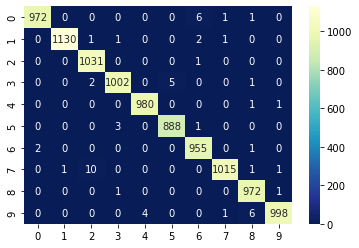

In [43]:
sns.heatmap(cm,cmap="YlGnBu_r",annot=True,fmt="d")